In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


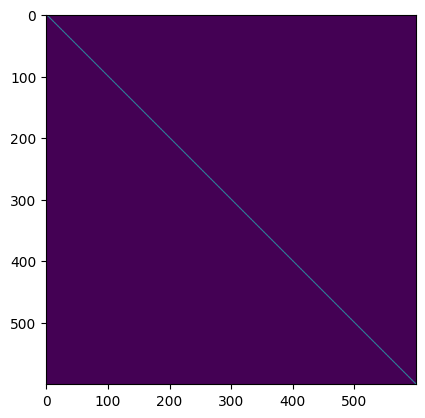

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
syl_cov = np.zeros((NE,NE))
K = 1
for i in range(NE//K):
    syl_cov[K*i:K*(i+1),K*i:K*(i+1)] = 2.5
syl_cov[np.arange(NE),np.arange(NE)] = 3
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)
# burst_ts -= 20

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

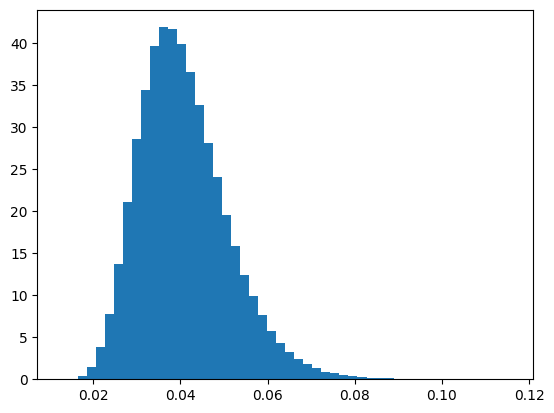

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 1
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# sEE *= 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)
plt.hist(JEE.flatten(), bins=50, density=True);

In [9]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
w0_mean, w0_std = 1/N_HVC, 0/N_HVC
w_inh, wI = w0_mean*0.2, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                         JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, 
                         wI=wI, w0_std=w0_std, cW=0.1)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 4465.07it/s]


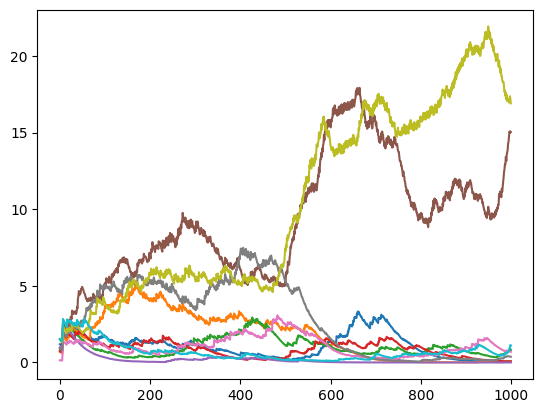

In [11]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(rE0, rI0, *aux, [], 1000, dt, 1)
rE, rI, Ws, mean_HVC_input, hE = _
plt.plot(rE[:1000,:10]);

In [12]:
def bilin_hebb(net, aiv_post, aiv_pre, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    # aux = (aiv_post[None,:] - 1) * hvc[:,None]
    # idx_E, idx_H, _ = sfind(net.W)
    # dW = lr * aux[idx_E,idx_H] - (net.W.data - 1/N_HVC)
    # net.W.data = np.clip(net.W.data + dW / tauW, a_min=1e-10, a_max=None)
    aux = (aiv_post[:,None] - 1) * (aiv_pre[None,:] - 1)
    dW = lr * aux - (net.JEE - w0_mean)
    net.JEE = np.clip(net.JEE + dW / tauW, a_min=0, a_max=None)

In [13]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-4e-1, asyn=20, w0_mean=JEE, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _

100%|████████████████████████████████████| 15499/15499 [00:33<00:00, 466.64it/s]


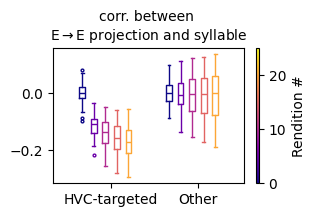

In [30]:
J_corrs = [correlation(_.T, syl) for _ in Ws]
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, N_rend-1] # rendition idx
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, sharey='all', figsize=(3, 2))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    sig = J_corrs[i][filt[0][filt[1]==q],p]
    bg = J_corrs[i][~filt[0][filt[1]==q],p]
    ax.boxplot([sig, bg], positions=[i/len(idx), 1.5+i/len(idx)],
               widths=0.5/len(idx), flierprops=dict(ms=2, mec=color), 
               boxprops=dict(color=color), capprops=dict(color=color),
               whiskerprops=dict(color=color), medianprops=dict(color=color))
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=N_rend))
fig.colorbar(sm, ax=ax, aspect=50, label='Rendition #')

ax.set(xticks=[0.5, 2], xticklabels=['HVC-targeted', 'Other'])
ax.set_title('corr. between \n' + r'E$\to$E projection and syllable', fontsize=10)
fig.tight_layout(pad=0.1)
fig.savefig('EI_rec_train_result.svg')

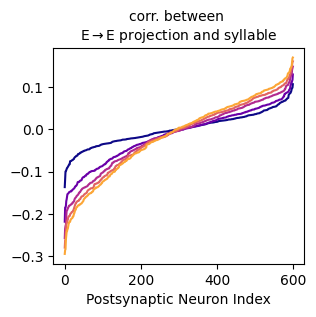

In [15]:
J_corrs = [correlation(_.T, syl) for _ in Ws]
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, -1]
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, sharey='all', figsize=(3, 3))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    ax.plot(np.sort(J_corrs[i][:,p]), c=color)
ax.set(xlabel='Postsynaptic Neuron Index')
ax.set_title('corr. between \n' + r'E$\to$E projection and syllable', fontsize=10)
fig.tight_layout(pad=0.1)

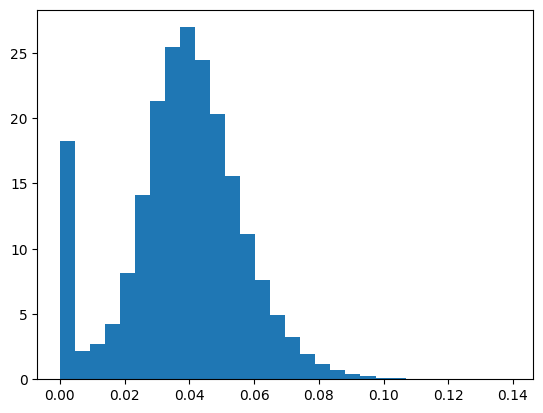

In [16]:
plt.hist(Ws[-1].flatten(), density=True, bins=30);

## Test Model with Unmatched Auditory Feedback

### Mismatch with completely independent patterns

In [17]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [18]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov, K = np.zeros((NE,NE)), 1
if K > 1:
    for i in range(NE//K):
        pert_cov[K*i:K*(i+1),K*i:K*(i+1)] = 7.5
pert_cov[np.arange(NE),np.arange(NE)] = 9
pert_args = [(pert_mean, pert_cov, 0)]
# K = 10
# pert_mean = np.zeros(NE)
# pert_mean[:K] = 2
# pert_cov = np.zeros((NE,NE))
# pert_cov[np.arange(NE),np.arange(NE)] = 1
# pert = rng.multivariate_normal(pert_mean, pert_cov, size=N_syl)
# pert_args = [(pert, 1)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 4384.00it/s]


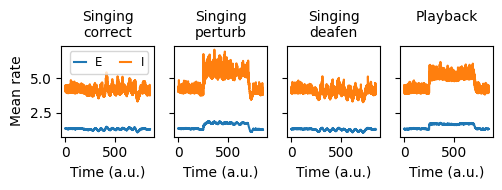

In [19]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all[0], test_names, ti, tj)

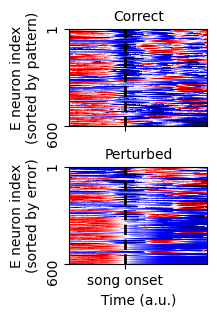

In [20]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all[0][0], tests_all[0][2], syl[0], tests_all[1][2][0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0], figsize=(2, 3))
# fig.savefig('err_response.svg')

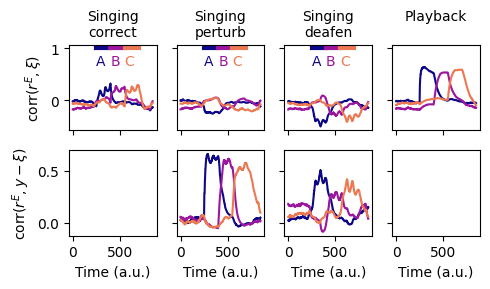

In [21]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all[2][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(tests_all[0], tests_all[1], syl, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

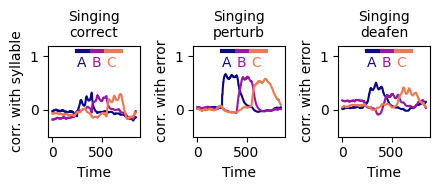

In [28]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all[2][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(tests_all[0][:-1], tests_all[1][:-1], syl, test_names[:-1],
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1.1)
fig.savefig('corr_EI_rec.svg')

265 335
84 66


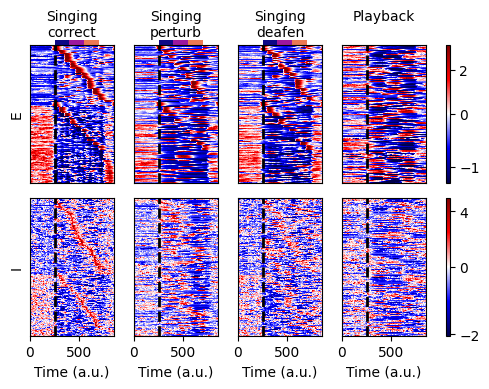

In [23]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all[0], test_names, ti, tj, T_burn, plot_inh=True, 
                            syl_order=so)

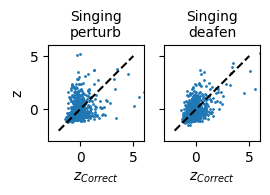

In [24]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all[0][:-1], test_names[:-1], ti, tj)
# fig.savefig('joint_dist_c_vs_nc_EI.svg')

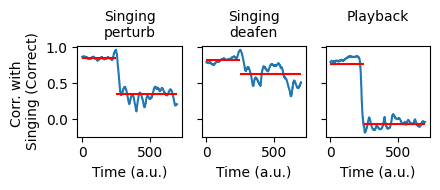

In [25]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all[0], test_names, ti, tj, T_burn)

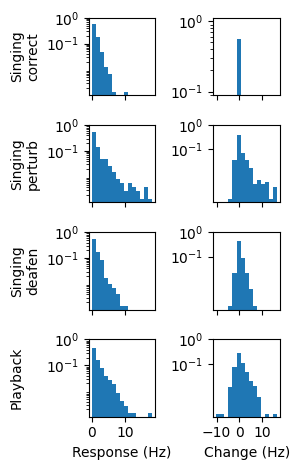

In [26]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all[0], test_names, ti, tj)

In [27]:
# # Mutual information
# r, x = test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0]
# joint_p = np.histogram2d(x, r, bins=50, density=True) # row is vertical dim.
# joint_p[0][:] += 1e-100
# p_r = np.histogram(r, bins=joint_p[2], density=True)
# p_r[0][:] += 1e-100
# p_x = np.histogram(x, bins=joint_p[1], density=True)
# p_x[0][:] += 1e-100
# dr, dx = joint_p[2][1] - joint_p[2][0], joint_p[1][1] - joint_p[1][0]
# h_x_given_r = -np.sum(joint_p[0] * (np.log(joint_p[0]) - np.log(p_r[0][None,:]))) * dr * dx
# h_x = -np.sum(p_x[0] * np.log(p_x[0])) * dx
# h_r = -np.sum(p_r[0] * np.log(p_r[0])) * dr
# h_x, h_r, h_x - h_x_given_r